In [618]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial
from numba import jit

# Define range of complex numbers
RE_START = -2
RE_END = 0.5
IM_START = -1.15
IM_END = 1.15

N_SAMPLES = 108211
CUBIC_N_SAMPLES = 108241 # 329^2
HALF_N_SAMPLES = 34898
CUBIC_HALF_N_SAMPLES = 34969 # 187^2


# Compute Mandelbrot set as f_c(z) = z^2 + c while z is in 
# range [-2, 2] and n below the maximum number of iterations
@jit
def mandelbrot(c, max_iter):
    z = n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
    return n

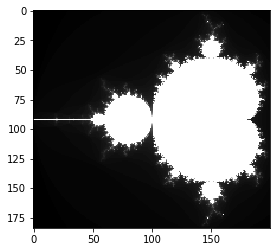

In [738]:
# Compute number of iterations possible in Mandelbrot calculation for 
# complex numbers in range [RE_START + IM_START * i, RE_END + IM_END * i]
image = np.zeros((184, 200))
for x, y in np.ndindex(image.shape):
    c = complex(RE_START + (y / image.shape[1]) * (RE_END - RE_START),
                    IM_START + (x / image.shape[0]) * (IM_END - IM_START))
    image[x,y] = mandelbrot(c, 100)
    
plt.imshow(image, cmap='gray')
plt
plt.savefig('Mandelbrot', dpi=500)
plt.show()

In [831]:
# Take s Monte Carlo samples from the Mandelbrot set
def monte_carlo_integration(i=100, s=100, sampling_method='random'):
    if sampling_method == 'latin_hypercube':
        samples = latin_hypercube_sampling(s)
    elif sampling_method == 'orthogonal':
        samples = orthogonal_sampling(s)
    else:
        samples = np.random.random((s,2))
    
    samples[:,0] = samples[:,0] * (RE_END - RE_START) + RE_START
    samples[:,1] = samples[:,1] * IM_END
    
    n = np.vectorize(mandelbrot)(samples.view(dtype=np.complex128), i)
    return (n == i).sum() / s * (RE_END - RE_START) * (IM_END - IM_START) 

In [790]:
def monte_carlo_integration_given_samples(i, samples):
    samples = np.copy(samples)
    samples[:,0] = samples[:,0] * (RE_END - RE_START) + RE_START
    samples[:,1] = samples[:,1] * IM_END

    n = np.vectorize(mandelbrot)(samples.view(dtype=np.complex128), i)
    return (n == i).sum() / len(samples) * (RE_END - RE_START) * (IM_END - IM_START) 

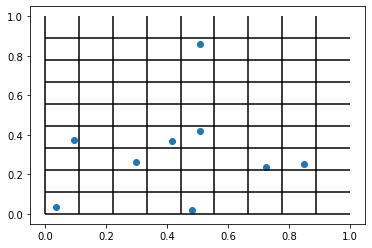

In [423]:
n = 3**2
s = np.random.random((n,2))
plt.figure()
plt.hlines(np.arange(n)/n, 0, 1)
plt.vlines(np.arange(n)/n, 0, 1)
plt.scatter(s[:,0], s[:,1])
plt.savefig('uniform_example', dpi=500)
plt.show()

In [176]:
def latin_hypercube_sampling(n_samples, n_dimensions=2):
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([np.random.permutation(range(n_samples)) for _ in range(n_dimensions)]).T
    return (samples + perms) / n_samples

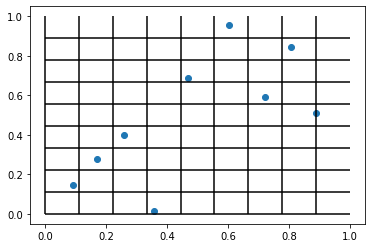

In [420]:
n = 3**2
s = latin_hypercube_sampling(n)
plt.figure()
plt.hlines(np.arange(n)/n, 0, 1)
plt.vlines(np.arange(n)/n, 0, 1)
plt.scatter(s[:,0], s[:,1])
plt.savefig('lhs_example', dpi=500)
plt.show()

In [177]:
def orthogonal_sampling(n_samples, n_dimensions=2):
    n_subspaces = np.sqrt(n_samples)
    if round(n_subspaces) != n_subspaces:
        raise ValueError('Square root of number of samples not a whole number')
    
    xlist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    ylist = np.arange(n_samples).reshape(int(n_subspaces),int(n_subspaces))
    
    for i in range(len(xlist)):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    
    samples = np.random.random((n_samples, n_dimensions))
    perms = np.array([[xlist[index], ylist[index[::-1]]] for index,_ in np.ndenumerate(xlist)])
    return (samples + perms) / n_samples

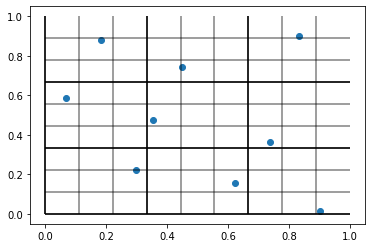

In [421]:
n = 3**2
s = orthogonal_sampling(n)
plt.figure()
plt.hlines(np.arange(n)/n, 0, 1, alpha=0.5)
plt.vlines(np.arange(n)/n, 0, 1, alpha=0.5)
plt.hlines(np.arange(np.sqrt(n))/np.sqrt(n), 0, 1)
plt.vlines(np.arange(np.sqrt(n))/np.sqrt(n), 0, 1)
plt.scatter(s[:,0], s[:,1])
plt.savefig('ortho_example', dpi=500)
plt.show()

## Plotting the variance

In [267]:
def plot_samples_variance(s_list, iterations=200, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(s_list, [iterations]*len(s_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    std = np.std(all_areas, axis=0)

    plt.plot(s_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, s_list[0], s_list[-1], linestyles='dashed', label = "Theoretical Mandelbrot area")
    plt.xlabel("Samples")
    plt.ylabel("Surface area")
    plt.fill_between(s_list, mean - std, mean + std, alpha = 0.3)
    plt.legend()
    plt.savefig("Convergence_samples_variance.png", dpi=500)
    plt.show()

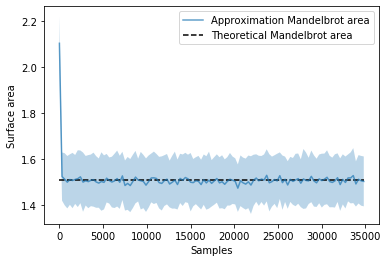

Process ForkPoolWorker-1541:
Process ForkPoolWorker-1539:
Process ForkPoolWorker-1540:
Process ForkPoolWorker-1542:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  

In [621]:
plot_samples_variance(np.arange(10,HALF_N_SAMPLES,300), 500, 100)

In [287]:
def plot_iterations_variance(i_list, samples=100, runs=100, sampling_method='random'):
    pool = mp.Pool(mp.cpu_count())

    all_areas = []
    for i in range(runs):
        areas = list(pool.starmap(partial(monte_carlo_integration, sampling_method=sampling_method), zip(i_list, [samples]*len(i_list))))
        all_areas.append(areas)

    mean = np.mean(all_areas, axis=0)
    std = np.std(all_areas, axis=0)
   
    plt.plot(i_list, mean, label = "Approximation Mandelbrot area", alpha = 0.7)
    plt.hlines(1.506484, i_list[0], i_list[-1], linestyles='dashed', label = "Mandelbrot area")
    plt.xlabel("Iterations")
    plt.ylabel("Surface area")
    plt.fill_between(i_list, mean - std, mean + std, alpha = 0.3)
    plt.legend()
    plt.savefig("Convergence_iterations_variance.png", dpi=500)
    plt.show()

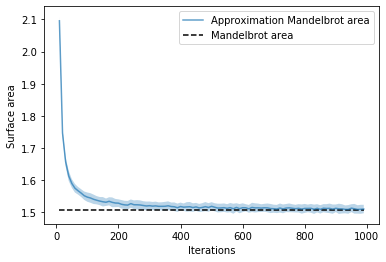

Process ForkPoolWorker-1543:
Process ForkPoolWorker-1545:
Process ForkPoolWorker-1544:
Process ForkPoolWorker-1546:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/jurrew27/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._a

In [622]:
plot_iterations_variance(np.arange(10,1000,10), HALF_N_SAMPLES, 100)

## Boxplots

In [591]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['caps'][1], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['whiskers'][1], color='blue')
    plt.setp(bp['medians'][0], color='blue')

    plt.setp(bp['boxes'][1], color='red')
    plt.setp(bp['caps'][2], color='red')
    plt.setp(bp['caps'][3], color='red')
    plt.setp(bp['whiskers'][2], color='red')
    plt.setp(bp['whiskers'][3], color='red')
    plt.setp(bp['medians'][1], color='red')
    
    plt.setp(bp['boxes'][2], color='green')
    plt.setp(bp['caps'][4], color='green')
    plt.setp(bp['caps'][5], color='green')
    plt.setp(bp['whiskers'][4], color='green')
    plt.setp(bp['whiskers'][5], color='green')
    plt.setp(bp['medians'][2], color='green')

    plt.setp(bp['boxes'][2], color='green')
    plt.setp(bp['caps'][4], color='green')
    plt.setp(bp['caps'][5], color='green')
    plt.setp(bp['whiskers'][4], color='green')
    plt.setp(bp['whiskers'][5], color='green')
    plt.setp(bp['medians'][2], color='green')

def boxplot_samples_variance(samples, iterations=100, runs=100):
    pool = mp.Pool(mp.cpu_count())

    areas = np.zeros((2,3,runs))
    
    areas[0][0] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='random'), [iterations]*runs))])
    areas[0][1] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='latin_hypercube'), [iterations]*runs))])        
    areas[0][2] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='orthogonal'), [iterations]*runs))])        

    areas[1][0] = np.array([list(pool.map(partial(antithetic_monte_carlo_integration, s=samples, sampling_method='random'), [iterations]*runs))])
    areas[1][1] = np.array([list(pool.map(partial(antithetic_monte_carlo_integration, s=samples, sampling_method='latin_hypercube'), [iterations]*runs))])
    areas[1][2] = np.array([list(pool.map(partial(antithetic_monte_carlo_integration, s=samples, sampling_method='orthogonal'), [iterations]*runs))])

    fig = plt.figure()
    ax = plt.axes()

    bp = plt.boxplot(areas[0].T, positions=[0,1,2], widths = 0.6, sym='')
    setBoxColors(bp)

    bp = plt.boxplot(areas[1].T, positions=[4,5,6], widths = 0.6, sym='')
    setBoxColors(bp)

    ax.set_xticklabels(['Not antithetic', 'Antithetic'])
    ax.set_xticks([1, 5])
    plt.ylabel('Surface area')
    
    hB, = plt.plot([1.506484,1.506484],'b-')
    hR, = plt.plot([1.506484,1.506484],'r-')
    hG, = plt.plot([1.506484,1.506484], 'g-')
    plt.legend((hB, hR, hG),('Uniform', 'Latin Hypercube', 'Orthogonal'))
    hB.set_visible(False)
    hR.set_visible(False)
    hG.set_visible(False)
    
    plt.savefig("Boxplot_different_optimizations.png", dpi=500)
    plt.show()
    pool.close()

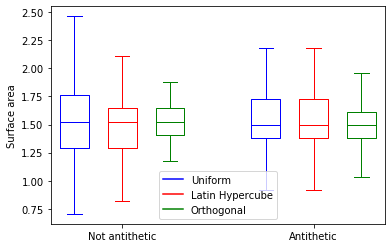

In [615]:
boxplot_samples_variance(samples=49, iterations=500, runs=1000)

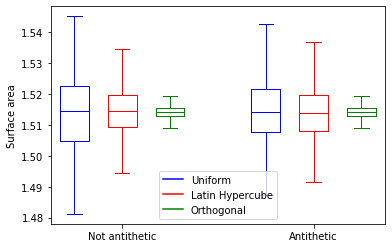

In [623]:
boxplot_samples_variance(samples=CUBIC_HALF_N_SAMPLES, iterations=500, runs=1000)

## Variance Reduction

In [602]:
def antithetic_monte_carlo_integration(i=100, s=100, sampling_method='randomn'):
    s = int(np.round(np.sqrt(s/2))**2)
    if sampling_method == 'latin_hypercube':
        samples = latin_hypercube_sampling(s)
    elif sampling_method == 'orthogonal':
        samples = orthogonal_sampling(s)
    else:
        samples = np.random.random((s,2))
    
    areas = monte_carlo_integration_given_samples(i, samples)
    antithetic_areas = monte_carlo_integration_given_samples(i, 1 - samples)
    
    return (areas + antithetic_areas) / 2

In [647]:
def control_variates(i=100, s=100, runs=100, sampling_method='random'):
    X = np.zeros(runs)
    Y = np.zeros(runs)
    for i in range(runs):
        if sampling_method == 'latin_hypercube':
            samples = latin_hypercube_sampling(s)
        elif sampling_method == 'orthogonal':
            samples = orthogonal_sampling(s)
        else:
            samples = np.random.random((s,2))

        X[i] = monte_carlo_integration_given_samples(i, samples)
        Y[i] = -np.mean(samples[:,0] + samples[:,1])
        
    print(np.var(X))
    print(np.cov(X,Y))
    
    c = - np.cov(X,Y)[0,1] / (1/6)
    return X + c * (Y - 1)

In [638]:
print(np.var(control_variates()))

0.7519589524999999
[[0.7595545  0.00090839]
 [0.00090839 0.00156567]]
0.7519491954547948


In [639]:
def boxplot_samples_variance_cv(iterations=100, samples=100, runs=100):
    pool = mp.Pool(mp.cpu_count())
    
    areas = np.zeros((2,runs))
    areas[0] = np.array([list(pool.map(partial(monte_carlo_integration, s=samples, sampling_method='random'), [iterations]*runs))])
    areas[1] = control_variates(iterations, samples, runs)
    
    plt.figure()
    plt.boxplot(areas.T, sym='', labels=['Uniform', 'Control Variate'])
    plt.xlabel('Sampling method')
    plt.ylabel('Surface area')
    plt.hlines
    plt.savefig("Boxplot_different_optimizations_cv.png", dpi=500)
    plt.show()
    
    pool.close()

0.21322489587671806
[[0.21343833 0.00150916]
 [0.00150916 0.00352474]]


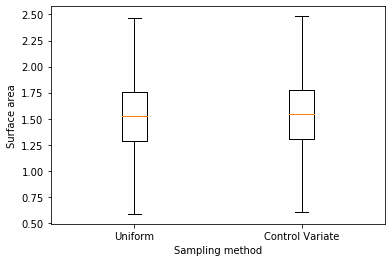

In [651]:
boxplot_samples_variance_cv(iterations=500, samples=49, runs=1000)

0.0793467653262668
[[7.94261915e-02 6.79237526e-06]
 [6.79237526e-06 4.53709235e-06]]


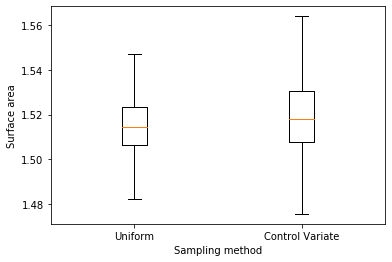

In [652]:
boxplot_samples_variance_cv(iterations=500, samples=HALF_N_SAMPLES, runs=1000)